In [96]:
import pandas as pd
from pandas import Series
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing


path = 'C:/Users/Kavish/Dropbox/_Master of Data Science - UM/WQD7005 - Data Mining/Assignment/Milestone 3/Notebooks/the_star_data.csv'
# df = pd.read_csv(path,parse_dates=['Datetime'])
df = pd.read_csv(path)
df.head(3)


,ID,Datetime,CompanySymbol,OpenPrice,HighPrice,LowPrice,LastPrice
0,207649,13 Mar 2019 - 7:13 PM,3A,0.85,0.855,0.845,0.850
1,207650,13 Mar 2019 - 7:13 PM,A50CHIN-C22,0.14,0.145,0.120,0.135
2,207651,13 Mar 2019 - 7:13 PM,A50CHIN-C24,0.67,0.670,0.670,0.670


In [47]:
df.drop('ID', axis=1, inplace=True)
df.drop_duplicates(subset=['Datetime', 'CompanySymbol'], inplace=True)
df = df.set_index('Datetime')
df.sort_index(inplace=True)

df.head(3)

,CompanySymbol,OpenPrice,HighPrice,LowPrice,LastPrice
Datetime,,,,,
01 Mar 2019 - 7:11 PM,SUNZEN-WB,0.030,0.030,0.030,0.030
01 Mar 2019 - 7:11 PM,GPA-WA,0.020,0.020,0.020,0.020
01 Mar 2019 - 7:11 PM,GPACKET,0.315,0.335,0.315,0.335


In [51]:
def getData(name):
    filter = df['CompanySymbol']==name
    new_data = df[filter]
    return new_data

print('Created function.')

Created function.


In [64]:
maybank = getData('MAYBANK')
maybank = maybank[['LastPrice']]
maybank.head(10)

,LastPrice
Datetime,
01 Mar 2019 - 7:11 PM,9.53
04 Mar 2019 - 1:06 PM,9.54
04 Mar 2019 - 5:19 PM,9.54
04 Mar 2019 - 7:11 PM,9.54
04 Mar 2019 - 9:21 AM,9.56
05 Mar 2019 - 1:06 PM,9.55
05 Mar 2019 - 5:19 PM,9.53
05 Mar 2019 - 7:11 PM,9.53
05 Mar 2019 - 9:21 AM,9.55


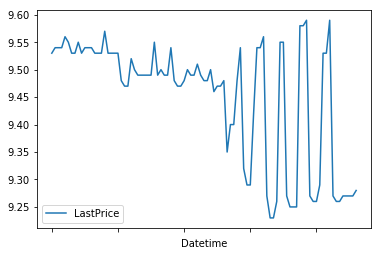

In [65]:
maybank.plot()

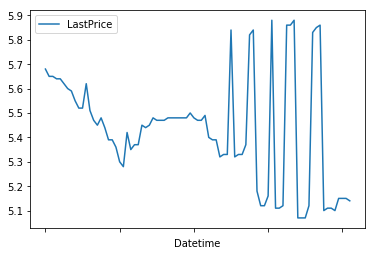

In [66]:
cimb = getData('CIMB')
cimb = cimb[['LastPrice']]
cimb.plot()

In [71]:
result = maybank.merge(cimb, on = 'Datetime',how='outer')
result.columns = ['MAYBANK','CIMB']
result.head()

,MAYBANK,CIMB
Datetime,,
01 Mar 2019 - 7:11 PM,9.53,5.68
04 Mar 2019 - 1:06 PM,9.54,NaN
04 Mar 2019 - 5:19 PM,9.54,NaN
04 Mar 2019 - 7:11 PM,9.54,5.64
04 Mar 2019 - 9:21 AM,9.56,NaN


In [73]:
from sklearn import preprocessing

In [77]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(result)
scaled_df = pd.DataFrame(scaled)
scaled_df.columns = ['MAYBANK','CIMB']
scaled_df.head()

,MAYBANK,CIMB
0,0.833333,0.753086
1,0.861111,NaN
2,0.861111,NaN
3,0.861111,0.703704
4,0.916667,NaN


In [78]:
scaled_df.cov()

,MAYBANK,CIMB
MAYBANK,0.097767,0.075837
CIMB,0.075837,0.078550


Text(0.5, 1.0, 'Raw time series')

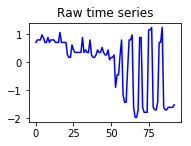

In [91]:
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation

scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(maybank.LastPrice)

n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(dataset[0].ravel(), "b-")
plt.title("Raw time series")

Text(0.5, 1.0, 'PAA')

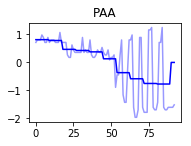

In [92]:
plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

Text(0.5, 1.0, 'SAX, 8 symbols')

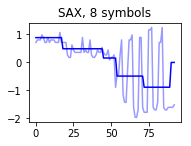

In [94]:
# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

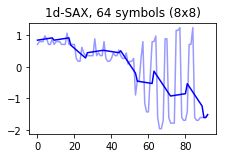

In [95]:
# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols_avg,
                                                alphabet_size_slope=n_sax_symbols_slope)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(one_d_sax.fit_transform(dataset))

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols (%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                                          n_sax_symbols_avg,
                                          n_sax_symbols_slope))

plt.tight_layout()
plt.show()